In [3]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import mofax as mofa
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
import torch
import torch.nn.functional as F
import random
import seaborn as sns
import muon as mu
import anndata
import scipy.sparse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

def to_device(t): return torch.tensor(t).to(device)

%load_ext autoreload
%autoreload 2
import pyromofa


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# dir="/scratch/deeplife/"
dir="/scratch/deeplife/projekt/data/"
neurips = anndata.read_h5ad(dir+"neurips2021.h5ad")
neurips.var_names_make_unique()
neurips.layers["counts"] = neurips.X.copy()

/scratch/venvs/deeplife2/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
protein = neurips[:, neurips.var["feature_types"] == "ADT"].copy()
rna = neurips[:, neurips.var["feature_types"] == "GEX"].copy()
rna = rna[:, rna.X.sum(axis=0) > 10].copy()
datasets = {
    'rna': rna.X,
    'protein': protein.X,
}

In [6]:
mofa = pyromofa.MOFA(datasets, K=10, batch_size=4096)
loss, map_estimates, trained_guide = mofa.train_epochs(num_epochs=90)
mofa_matrices = mofa.get_matrices()

/scratch/deeplife/DeepLife_MoFa2/prague_group/pyromofa.py:25: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(matrix.indptr, matrix.indices, matrix.data, size=matrix.shape, device=device)


Observation masks: {'rna': None, 'protein': None}


/scratch/venvs/deeplife2/lib/python3.12/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'latent factors'}
  warnings.warn(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/pyro/util.py:544: UserWarning: s_rnaFound sample sites configured for enumeration:, s_protein
If you want to enumerate sites, you need to use TraceEnum_ELBO instead.
  warnings.warn(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'latent factors'}
  warnings.warn(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/pyro/util.py:544: UserWarning: s_rnaFound sample sites configured for enumeration:, s_protein
If you want to enumerate sites, you need to use TraceEnum_ELBO instead.
  warnings.warn(


[00:02 iteration 01:00023] loss: 15881.2924
[00:04 iteration 02:00046] loss: 15425.9084
[00:06 iteration 03:00069] loss: 14961.1221
[00:07 iteration 04:00092] loss: 14489.1569
[00:09 iteration 05:00115] loss: 14188.6953
[00:11 iteration 06:00138] loss: 13719.0384
[00:13 iteration 07:00161] loss: 13286.2277
[00:14 iteration 08:00184] loss: 12954.1431
[00:16 iteration 09:00207] loss: 12626.2008
[00:18 iteration 10:00230] loss: 12271.1382
[00:20 iteration 11:00253] loss: 11957.0178
[00:21 iteration 12:00276] loss: 11660.4090
[00:23 iteration 13:00299] loss: 11310.6917
[00:25 iteration 14:00322] loss: 11124.2696
[00:27 iteration 15:00345] loss: 10810.0106
[00:28 iteration 16:00368] loss: 10575.9096
[01:30 iteration 17:00391] loss: 10355.1003
[01:32 iteration 18:00414] loss: 10127.6124
[01:33 iteration 19:00437] loss: 9955.7127
[01:35 iteration 20:00460] loss: 9698.5544
[01:37 iteration 21:00483] loss: 9523.3654
[01:39 iteration 22:00506] loss: 9383.9928
[01:40 iteration 23:00529] loss: 918

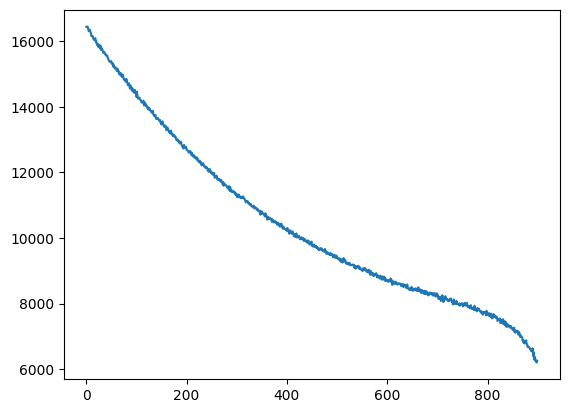

In [13]:
plt.plot(loss[:900])

In [86]:
# sns.heatmap(mofa_matrices.Ws['rna'].T)

In [8]:
#mofa.train(num_iterations=40000)
trained_guide()['scale_protein'].min()

tensor(0.2849, device='cuda:0', grad_fn=<MinBackward1>)

In [37]:
print(pyro.get_param_store().keys())

dict_keys(['AutoGuideList.0.locs.theta_rna', 'AutoGuideList.0.scales.theta_rna', 'AutoGuideList.0.locs.alpha_rna', 'AutoGuideList.0.scales.alpha_rna', 'AutoGuideList.0.locs.W_rna', 'AutoGuideList.0.scales.W_rna', 'AutoGuideList.0.locs.theta_protein', 'AutoGuideList.0.scales.theta_protein', 'AutoGuideList.0.locs.alpha_protein', 'AutoGuideList.0.scales.alpha_protein', 'AutoGuideList.0.locs.W_protein', 'AutoGuideList.0.scales.W_protein', 'AutoGuideList.0.locs.Z', 'AutoGuideList.0.scales.Z', 'AutoGuideList.0.locs.precision_rna', 'AutoGuideList.0.scales.precision_rna', 'AutoGuideList.0.locs.scale_rna', 'AutoGuideList.0.scales.scale_rna', 'AutoGuideList.0.locs.precision_protein', 'AutoGuideList.0.scales.precision_protein', 'AutoGuideList.0.locs.scale_protein', 'AutoGuideList.0.scales.scale_protein', 'AutoGuideList.1.s_rna_probs', 'AutoGuideList.1.s_protein_probs'])


In [46]:
pyro.get_param_store()['AutoGuideList.0.locs.theta_rna']

Parameter containing:
tensor([0.6259, 1.2300, 1.8438, 1.8469, 1.8140], device='cuda:0',
       requires_grad=True)

In [17]:
R2 = { m:
          1 - np.sum(
              (
                  np.expm1(
                      mofa_matrices.Z.numpy() @ mofa_matrices.Ws[m].numpy().T * mofa.empirical_stds[m].cpu().numpy()
                      + mofa.empirical_means[m].cpu().numpy()
                  ) - Y.A
              ) ** 2
          ) / Y.power(2).sum() for m, Y in datasets.items() }
R2

{'rna': 0.0001837015151977539, 'protein': -0.7931164503097534}

In [16]:
R2 = { m:
          1 - np.sum(
              (
                  (mofa_matrices.Z.numpy() @ mofa_matrices.Ws[m].numpy().T * mofa.empirical_stds[m].cpu().numpy() + mofa.empirical_means[m].cpu().numpy()) - Y.log1p().A
              ) ** 2
          ) / Y.log1p().power(2).sum() for m, Y in datasets.items() }
R2

{'rna': 0.49918293952941895, 'protein': 0.6181584894657135}

In [101]:
mofa.save_h5(neurips.obs.index, { "rna": rna, "protein": protein }, "/scratch/deeplife/projekt/models/pyro-MOFA-neurips2.h5", compression=1)
np.savez("/scratch/deeplife/projekt/models/pyro-MOFA-neurips.npz", Z=mofa_matrices.Z)

dict_keys(['AutoGuideList.0.locs.alpha_rna', 'AutoGuideList.0.scales.alpha_rna', 'AutoGuideList.0.locs.W_rna', 'AutoGuideList.0.scales.W_rna', 'AutoGuideList.0.locs.alpha_protein', 'AutoGuideList.0.scales.alpha_protein', 'AutoGuideList.0.locs.W_protein', 'AutoGuideList.0.scales.W_protein', 'AutoGuideList.0.locs.Z', 'AutoGuideList.0.scales.Z', 'AutoGuideList.0.locs.precision_rna', 'AutoGuideList.0.scales.precision_rna', 'AutoGuideList.0.locs.scale_rna', 'AutoGuideList.0.scales.scale_rna', 'AutoGuideList.0.locs.precision_protein', 'AutoGuideList.0.scales.precision_protein', 'AutoGuideList.0.locs.scale_protein', 'AutoGuideList.0.scales.scale_protein'])


In [71]:
import mofax
mofax_model = mofax.mofa_model('/scratch/deeplife/projekt/models/pyro-MOFA-neurips2.h5')

(10, 90261) (10, 134)


/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1093: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2 = r2.append(tmp)
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: Futu

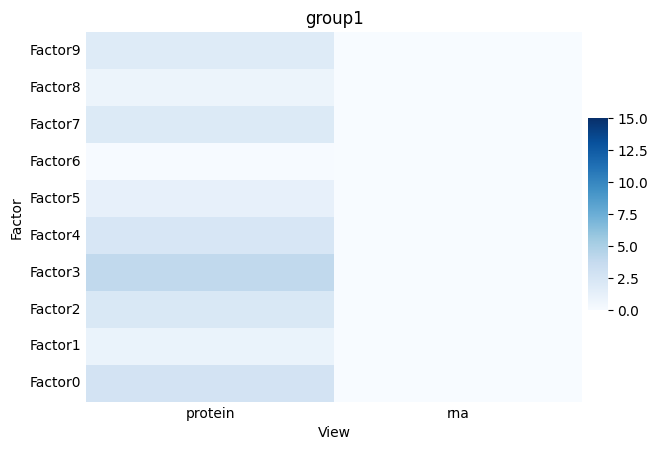

In [72]:
mofax_model
print(mofax_model.factors['group1'].shape, mofax_model.weights['protein'].shape)
mofax.plot_r2(mofax_model, x='View', vmax=15)

In [100]:
mofax_model.get_r2()

/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1093: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2 = r2.append(tmp)
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: Futu

,View,Group,R2,Factor
0,protein,group1,2.777487,Factor0
1,rna,group1,0.000656,Factor0
0,protein,group1,0.968140,Factor1
1,rna,group1,0.000525,Factor1
0,protein,group1,2.278841,Factor2
1,rna,group1,0.000268,Factor2
0,protein,group1,4.040116,Factor3
1,rna,group1,0.000578,Factor3
0,protein,group1,2.450657,Factor4
1,rna,group1,0.000709,Factor4


In [ ]:
protein_regen = mofa_matrices.Z @ mofa_matrices.Ws["protein"].T

In [ ]:
protein_regen

tensor([[48.7864, 50.1672, 34.5717,  ...,  3.5688,  3.5712,  4.3290],
        [47.4409, 48.8288, 33.5734,  ...,  3.3584,  3.4070,  4.0482],
        [43.4831, 44.8272, 30.7245,  ...,  2.8329,  2.9679,  3.3625],
        ...,
        [38.8808, 39.9130, 27.7137,  ...,  2.6211,  2.5719,  3.2265],
        [48.1160, 49.6041, 33.9555,  ...,  3.3274,  3.4781,  3.9350],
        [20.4948, 21.0338, 14.5923,  ...,  1.4712,  1.4299,  1.8209]])

In [ ]:
protein.X.toarray()

array([[ 12., 280.,   9., ...,   5.,   2.,   4.],
       [ 24., 231.,  11., ...,   0.,   1.,   1.],
       [ 23., 117.,   3., ...,   1.,   4.,   2.],
       ...,
       [279.,   6., 331., ...,   1.,   2.,   3.],
       [ 11., 133.,  10., ...,   5.,   2.,   5.],
       [441., 658.,   4., ...,   2.,   3.,   2.]], dtype=float32)